In [18]:
# Importando bibliotecas

import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

from scipy.spatial import distance as dist

from io import BytesIO
from IPython.display import clear_output, Image, display
from PIL import Image as Img

In [19]:
# Código para captura de vídeo

def padronizar_imagem(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (500, 400))
    return frame

def exibir_video(frame):
    img = Img.fromarray(frame, "RGB")
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    display(Image(data=buffer.getvalue()))
    clear_output(wait=True)

In [20]:
# Instância modelo dlib

classificador_path = "classificadores/shape_predictor_68_face_landmarks.dat"

classificador_dlib = dlib.shape_predictor(classificador_path)

# Método dlib para reconhecimento facial
detector_face = dlib.get_frontal_face_detector()

In [21]:
#Constantes de marcos faciais

FACE = list(range(17, 68))
FACE_COMPLETA = list(range(0, 68))
LABIO = list(range(48, 61))
SOMBRANCELHA_DIREITA = list(range(17, 22))
SOMBRANCELHA_ESQUERDA = list(range(22, 27))
OLHO_DIREITO = list(range(36, 42))
OLHO_ESQUERDO = list(range(42, 48))
NARIZ = list(range(27, 35))
MANDIBULA = list(range(0, 17))

# Método para ler o vídeo e obter marcos faciais 

def pontos_marcos_faciais(imagem):
    retangulos = detector_face(imagem, 1)

    if len(retangulos) == 0:
        return None

    marcos = []

    for retangulo in retangulos:
        marcos.append(np.matrix([[p.x, p.y] for p in classificador_dlib(imagem, retangulo).parts()]))

    return marcos

In [22]:
# Distância euclidiana para verificar abertura olhos

def EAR(pontos_olhos):
    
    a = dist.euclidean(pontos_olhos[1], pontos_olhos[5])
    b = dist.euclidean(pontos_olhos[2], pontos_olhos[4])
    c = dist.euclidean(pontos_olhos[0], pontos_olhos[3])
    
    aspecto_razao = (a + b)/(2.0 * c)
    
    return aspecto_razao

In [23]:
def anotar_marcos(imagem, marcos):
    retangulos = detector_face(imagem, 1)
    
    if len(retangulos) == 0:
        return None
    
    for idx, ret in enumerate(retangulos):
        marco = marcos[idx]
        
        pontos = cv2.convexHull(marco[OLHO_ESQUERDO])
        cv2.drawContours(imagem, [pontos], 0, (0,255,0), 1)
        
        pontos = cv2.convexHull(marco[OLHO_DIREITO])
        cv2.drawContours(imagem, [pontos], 0, (0,255,0), 1)
    
    return imagem

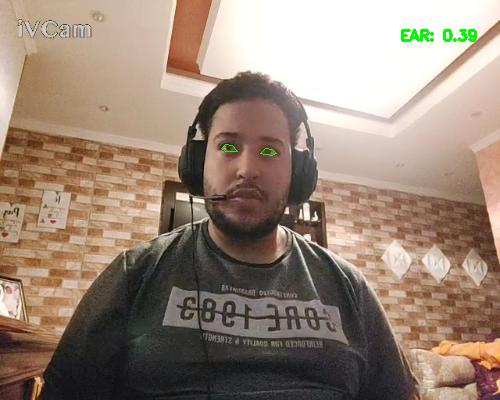

In [ ]:
ABERTURA_MAX = 0.3
FRAMES_MAX = 3
COUNT = 0

# Detecção olhos

try:
    video = cv2.VideoCapture(0)
    
    while(True):
        captura_ok, frame = video.read()
        frame = padronizar_imagem(frame)
        
        marcos_faciais = pontos_marcos_faciais(frame)
        
        if marcos_faciais is not None:
            ar_olho_esq = EAR(marcos_faciais[0][OLHO_ESQUERDO])
            ar_olho_dir = EAR(marcos_faciais[0][OLHO_DIREITO])
            
            ar_olho_esq = round(ar_olho_esq, 3)
            ar_olho_dir = round(ar_olho_dir, 3)
            
            ear = (ar_olho_esq + ar_olho_dir) / 2.0
            
            if ear < ABERTURA_MAX:
                COUNT += 1
                cv2.putText(frame, "EAR: {:.2f}".format(ear), (400,40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 250, 0), 2)
                
                if COUNT >= FRAMES_MAX:
                    cv2.putText(frame, "ALERTA DE SONO!!!", (150, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2) 
                    cv2.putText(frame, "EAR: {:.2f}".format(ear), (400,40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (250, 0, 0), 2)
            else:
                COUNT = 0
                cv2.putText(frame, "EAR: {:.2f}".format(ear), (400,40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 250, 0), 2)
            
            frame = anotar_marcos(frame, marcos_faciais)
            
            
            
        exibir_video(frame)
        
except KeyboardInterrupt:
    video.release()
    print("Interrompido")